In [45]:
pip install ISLP

In [46]:
# imports from the islp lab
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestClassifier as RF,
      GradientBoostingClassifier as GBR)


In [47]:
data = pd.read_csv("full_dataset.csv")


In [65]:
# setup for making a model

# multicorrelated predictors (decided in the svm file) are removed
model = MS(data.drop(['County', 'State', 'Population.2020 Population','Population.2010 Population', 'Employment.Firms.Total',
             'Employment.Firms.Women-Owned', 'Employment.Firms.Men-Owned', 'Employment.Firms.Minority-Owned',
             'Employment.Firms.Nonminority-Owned', 'Employment.Firms.Veteran-Owned', 'Employment.Firms.Nonveteran-Owned',
             'county_names_with_casing', 'county_fips', 'total_votes_2020', 'total_votes_2016', 'total_votes_2012', 'total_votes_2008',
             'total_votes_2004', 'total_votes_2000', 'prop_favored_dem_2020', 'prop_favored_dem_2016', 'prop_favored_dem_2012',
             'prop_favored_dem_2008', 'prop_favored_dem_2004', 'prop_favored_dem_2000', 'winner_2020'], axis=1), intercept=False)

D = model.fit_transform(data)
feature_names = list(D.columns)
winner = data[["winner_2020"]].values.ravel()
X = np.asarray(D)




In [66]:
# train test split
(X_train,
X_test,
y_train,
y_test) = skm.train_test_split(X,
                                   winner,
                                   test_size=0.2,
                                   random_state=0)

In [67]:
# no max depth is given, as that is found through cross validation
# base tree before pruning
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

0.8949044585987261

test accuracy of 89% without pruning without election results

In [68]:
# making a tree with pruning
ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)

This yields a set of impurities and $\alpha$
 values from which we can extract an optimal one by cross-validation.

In [69]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_score_

0.9074948207171316

While train accuracy didn't go down that much, it still seems incredibly high for a basic model.

Anyways, the basic model is:

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_export.py:670: UserWarning: Glyph 9 (	) missing from current font.
  ann.update_bbox_position_size(renderer)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


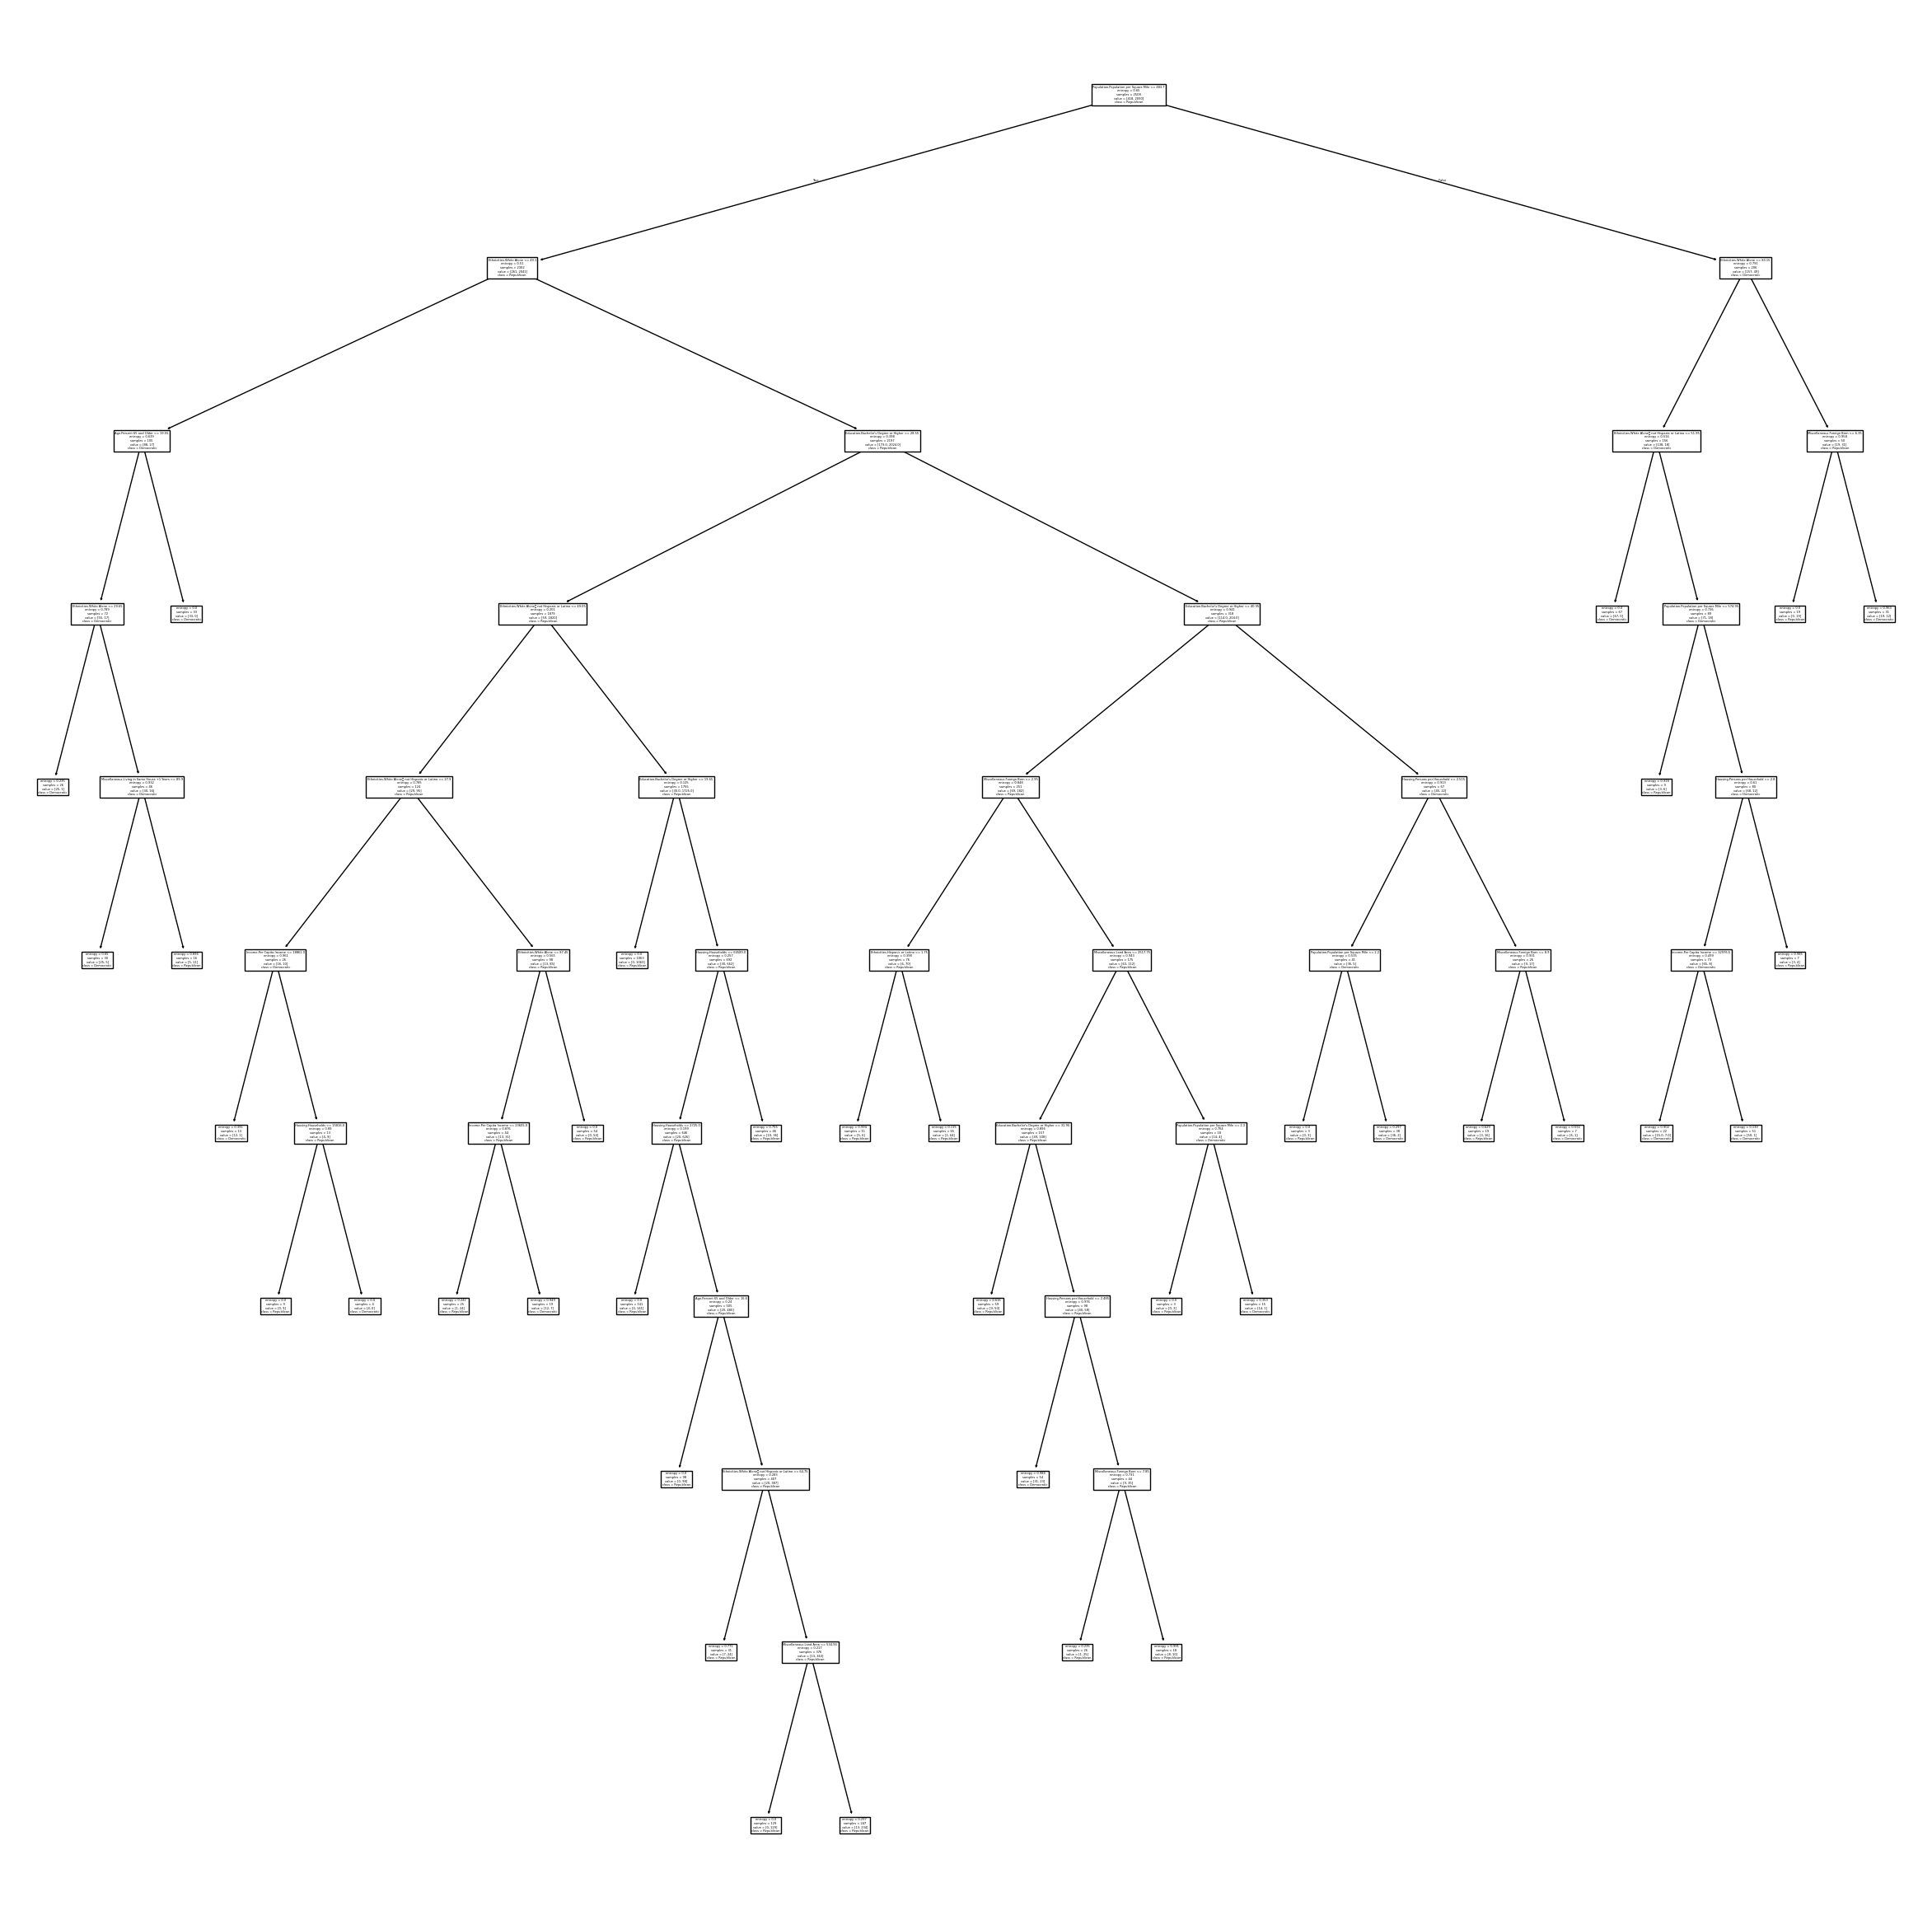

In [70]:
# plotting the tree
ax = subplots(figsize=(30, 30))[1] # the figsize needs to be increased to make them readable
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax, class_names = ["Democratic","Republican"]);


In [71]:
print(export_text(best_,
                  feature_names=feature_names,
                  show_weights=True))

|--- Population.Population per Square Mile <= 483.70
|   |--- Ethnicities.White Alone <= 49.10
|   |   |--- Age.Percent 65 and Older <= 19.55
|   |   |   |--- Ethnicities.White Alone <= 29.65
|   |   |   |   |--- weights: [25.00, 1.00] class: Democrat
|   |   |   |--- Ethnicities.White Alone >  29.65
|   |   |   |   |--- Miscellaneous.Living in Same House +1 Years <= 89.90
|   |   |   |   |   |--- weights: [25.00, 5.00] class: Democrat
|   |   |   |   |--- Miscellaneous.Living in Same House +1 Years >  89.90
|   |   |   |   |   |--- weights: [5.00, 11.00] class: Republican
|   |   |--- Age.Percent 65 and Older >  19.55
|   |   |   |--- weights: [33.00, 0.00] class: Democrat
|   |--- Ethnicities.White Alone >  49.10
|   |   |--- Education.Bachelor's Degree or Higher <= 28.55
|   |   |   |--- Ethnicities.White Alone	 not Hispanic or Latino <= 49.05
|   |   |   |   |--- Ethnicities.White Alone	 not Hispanic or Latino <= 27.90
|   |   |   |   |   |--- Income.Per Capita Income <= 18861.00
|

In [72]:
best_.tree_.n_leaves


36

In [73]:
# on test data
print(accuracy_score(y_test,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            y_test)
confusion

0.9028662420382165


Truth,Democrat,Republican
Predicted,,
Democrat,91,22
Republican,39,476


correct 70% democrat counties, 95.6% of the time on republican counties. Pruning seemed to improve the test error of the model. This version performs way worse than the version with states did on democrats specifically, but marginally better on republicans

Random Forests

In [74]:
forest = RF(random_state=0).fit(X_train, y_train)
y_hat_RF = forest.predict(X_test)
# np.mean((y_test - y_hat_RF)**2)
np.sum(y_test == y_hat_RF) / len(y_test)

0.9315286624203821

Oddly, adding a max features of 6 here has a higher test accuracy than with no max features

In [75]:
feature_imp = pd.DataFrame(
    {'importance':forest.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Ethnicities.White Alone,0.153393
Education.Bachelor's Degree or Higher,0.131812
Ethnicities.White Alone\t not Hispanic or Latino,0.116211
Population.Population per Square Mile,0.110382
Housing.Households,0.099446
Income.Per Capita Income,0.047924
Miscellaneous.Foreign Born,0.044389
Miscellaneous.Language Other than English at Home,0.039397
Housing.Persons per Household,0.037811
Income.Median Houseold Income,0.035817


In [76]:
confusion_table(y_hat_RF, y_test)

Truth,Democrat,Republican
Predicted,,
Democrat,96,9
Republican,34,489


The random forest in this case performs better than the pruned tree, and has a higher test accuracy than the models that had states.

73.8% accurate on democrats. 98.2% accurate on republicans